In [1]:
import numpy as np

import matplotlib
#matplotlib.use('WebAgg')
#matplotlib.use('Qt4Cairo')
#matplotlib.use('Qt5Cairo')
matplotlib.use('nbAgg')
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
class Cube:
    def __init__(self,center,distance):
        self.center=center
        self.distance=distance
        self.dim=len(center)
        self.volume=(2*self.distance)**self.dim

        self.generate_signs()#this list will hep us move a point towards backwards and forward directions in all axes 

    def generate_signs(self):
        '''
        The code below generates a list of signs that will move a point to all posible directions.
        Example for 2 dimensions this will give us
        
        [
            [1,1],
            [1,-1],
            [-1,1],
            [-1,-1]
        ]
        
        In three dimensions  
        [
            [1, 1, 1],
            [1, 1, -1],
            [1, -1, 1],
            [1, -1, -1],
            [-1, 1, 1],
            [-1, 1, -1],
            [-1, -1, 1],
            [-1, -1, -1]
        ]
        
        I came up with this code by trying different things and simplifying the result.
        
        What you need to do to replicate it is to draw on a board what you wat to do:
        take all possible combinations od size=self.dim of a list of +1 and -1 (there are dim**2 combinations).
        What you need to do is understand how to do this:
        
        + +
        + -
        - +
        - -
        
        Then this
        + + +
        + + -
        + - +
        + - -
        - + +
        - + -
        - - +
        - - -
        
        Then the pattern emerges: the last one changes every 1 step the second to last every 2, third to last every 4. 
        Translate this into a for-loop, and you have your result :)
        '''
        self.signs=[[0 for __ in range(self.dim)] for _ in range(2**self.dim)]
        for j in range(self.dim):
            count=0
            for i in range(2**self.dim):
                self.signs[i][j]=(-1)**count
                if (i+1)%(2**(self.dim-1-j))==0:
                    count+=1
                    if count==2:
                        count=0 

    def check_point(self,point):
        '''check whether point is inside this square'''
        for i in range(self.dim):
            if point[i]>self.center[i]+self.distance or point[i]<self.center[i]-self.distance:
                return False
        
        return True
    
    def random_point(self):
        '''generate a random point in this cube'''
        point=[]
        for d in range(self.dim):
            _M=self.center[d]+self.distance
            _m=self.center[d]-self.distance
            point.append(np.random.rand()*(_M-_m)+_m)
            
        return point

In [3]:
class DTree:
    '''
    The DTree class recursively subdivides the space.
    '''
    def __init__(self,boundary,integrand,number_of_points,depth=0,max_depth=50):
        '''
        boundary: an instance of Cube. It is the cube that defines this "node" of the tree.
        function: the function whose edges we want to find
        max_depth: number of allowed subdivisions
        number_of_points: draw number_of_points at random in each cube to see if there is an edge. 
        '''
        
        #We deal with cubes, but use the dim when you can. It will be easier to generalize later.
        self.dim=boundary.dim
        
        self.boundary=boundary
        self.integrand=integrand
        self.number_of_points=number_of_points
        self.max_depth=max_depth
        self.depth=depth
        
        #List of intances of DTree. This will hold the potential cubes.
        #Each instance of DTree has either 0 or dim**2 children.
        self.children=[0 for i in range(2**self.dim)]  
        self.has_children=False
        
                        
    def subdivide(self):
        '''Subdivide the cube'''
        self.has_children=True
        new_distance = self.boundary.distance/2. #the distance of all new cubes
        for i in range(2**self.dim):
            new_center = [ self.boundary.signs[i][d]*new_distance + self.boundary.center[d] for d in range(self.dim)]
            child = Cube( new_center , new_distance )
            self.children[i]=DTree(child,self.integrand,self.number_of_points,self.depth+1,self.max_depth)
        
    
    def integrate(self):
        Sum=0
        Sum_sq=0
        for i in range(self.number_of_points):
            r=self.boundary.random_point()
            val=self.integrand(r)
            Sum+=val*self.boundary.volume
            Sum_sq+=val*val/(self.boundary.volume)**2.

        return Sum/self.number_of_points, (Sum_sq-Sum*Sum/self.number_of_points)/(self.number_of_points-1)
        
    def push(self):
        '''This finds the subdivides the child with the maximum relative error (given that it is large enough).
        I want to only subdivide the cube with the maximum relative error out of all the children.
        We need to return the relative error and what child has it, so that we can subdivide it when we go out 
        of this function.
        
        '''
        abs_tol=1e-2
        rel_tol=1e-2

        if self.has_children:
            mean = 0
            variance = 0
            max_D=0
            max_ch=self.children[0]
            for ch in self.children:
                r=ch.push()
                mean += r[0]
                variance+=r[1]/self.number_of_points
                
                _sc=(abs_tol+rel_tol*np.abs(r[0]))
                delta=np.abs((r[1]**0.5-r[0])/r[0])
                
                if (delta/_sc)>max_D:
                    max_D=(delta/_sc)
                    max_ch=ch

            if (delta/_sc)>1:
                max_ch.subdivide()
        else:
            r=self.integrate()        
            mean=r[0]
            variance=r[1]
            
            
            _sc=(abs_tol+rel_tol*np.abs(mean))
            delta=np.abs((variance**0.5-mean)/mean)
            if (delta/_sc)>1:
                self.subdivide()
        
        return  mean,variance
                
    
    def get_cubes(self):
        '''Get the cubes of the tree and its children  recursively'''
        cubes=[self.boundary]
        if self.has_children:
            for i in self.children:
                for c in i.get_cubes():
                    cubes.append(c)
        return cubes

In [14]:
def func(x):
    return np.exp(-(x[0]-0.2)**2*1000)


In [44]:
Qt=DTree(Cube([0.5],0.5),func,2000,0,10)    

In [53]:
for i in range(5):
    Qt.push()

In [54]:
Qt.integrate()

(0.057131252684269496, 0.03843600498084572)

<IPython.core.display.Javascript object>


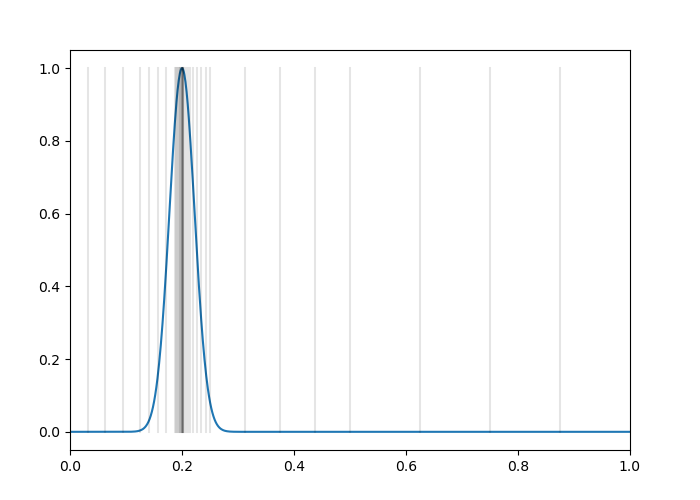

In [55]:
fig=plt.figure(figsize=(7,5))
fig.subplots_adjust(bottom=0.1, left=0.1, top = 0.9, right=0.9,wspace=0.0,hspace=0.5)




sub = fig.add_subplot(111)

cc=np.array(Qt.get_cubes())

X=np.linspace(0,1,1000)
sub.plot(X,[func([x]) for x in X])

for c in cc:
    sub.plot([c.center[0]]*2,[0,1],color='xkcd:black',alpha=0.1)



sub.set_xlim(0,1)
# sub.set_ylim(0,1) 
plt.show()

In [9]:
def func(x):
    return np.exp(-((x[0]-0.5)**2+(x[1]-0.4)**2)*5000)


In [10]:
Qt=DTree(Cube([0.5,0.5],0.5),func,200,0,10)    

In [11]:
for i in range(8):
    Qt.push()

<ipython-input-3-8637567efbfd>:82: RuntimeWarning: invalid value encountered in double_scalars
  delta=np.abs((variance**0.5-mean)/mean)
<ipython-input-3-8637567efbfd>:67: RuntimeWarning: invalid value encountered in double_scalars
  delta=np.abs((r[1]**0.5-r[0])/r[0])


In [12]:
Qt.integrate()

(0.00044896683813993546, 3.707445129258036e-05)

<IPython.core.display.Javascript object>


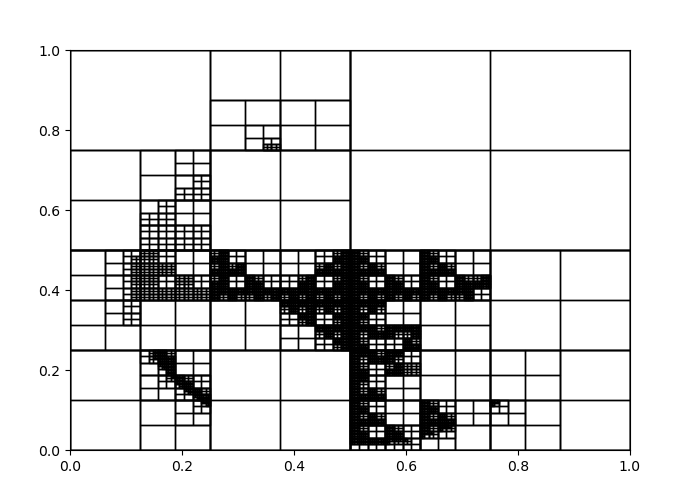

In [13]:
fig=plt.figure(figsize=(7,5))
fig.subplots_adjust(bottom=0.1, left=0.1, top = 0.9, right=0.9,wspace=0.0,hspace=0.5)




sub = fig.add_subplot(111)


sq=np.array(Qt.get_cubes())
for _ in sq:
    sub.add_patch(
        Rectangle((_.center[0]-_.distance,_.center[1]-_.distance), _.distance*2, _.distance*2,
        facecolor='none',edgecolor='xkcd:black'),
    )


sub.set_xlim(0,1)
# sub.set_ylim(0,1) 
plt.show()